In [1]:
import pkgutil
import importlib
import logging
import traceback
from collections import defaultdict
import random
import copy
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as P
import matplotlib.pyplot as plt

matplotlib.use ('Agg')

%matplotlib inline

In [73]:
class Torneio(object):
    def __init__(self, jogadores):
        self.historico = defaultdict(lambda: {"comida": [], "reputacao": [], "cacou": 0, "descansou": 0})
        self.contenders = jogadores # dicionario com as instancias dos jogadores;
        self.recompensa = []
        self.cemiterio = {}
        self.rodada = 0
        self.bugados = {}
        self.M = [] #série de m
        

    @property
    def p(self):
        if self.jogadores is None:
            return 0
        return len(self.jogadores)

    def inicializa_jogadores(self, comida=300.0):
        self.jogadores = {x:importlib.import_module("estrategias.{}".format(x)).MeuJogador() for x in self.contenders}
        for nome, jogador in self.jogadores.items():
            self.historico[nome]["comida"].append(comida*(self.p-1))
            self.historico[nome]["reputacao"].append(0.)
        self.inicializa_saida()

    def inicializa_saida(self):
        mode = "w"
        cabecalho = ','.join(self.historico.keys()) + '\n'
        with open("comida.csv", mode) as f:
            f.write(cabecalho)
        with open("reputacao.csv", mode) as f:
            f.write(cabecalho)
        with open("recompensa.csv", mode) as f:
            f.write("recompensa\n")

    def roda_rodada(self):
        """
        Coleta as escolhas de cada jogador
        """
        self.rodada += 1
        if self.rodada%20 == 0:
            print("Iniciando Rodada {}".format(self.rodada))
        jogadores_randomizados = [jog for jog in self.jogadores.keys() if jog not in self.bugados]
        random.shuffle(jogadores_randomizados)
        m = random.randrange(0, self.p*(self.p-1))
        self.M.append(m)
        escolhas = {}
        
        for nome in jogadores_randomizados:
            jogador = self.jogadores[nome]
            adversarios = copy.copy(jogadores_randomizados)
            adversarios.remove(nome)
            reputacoes = tuple([self.historico[nome_adv]["reputacao"][-1] for nome_adv in adversarios])
            try:
                escolhas[nome] = (jogador.escolha_de_cacada(self.rodada, self.historico[nome]["comida"][-1],
                                                            self.historico[nome]["reputacao"][-1],
                                                            m, 
                                                            reputacoes), 
                                  tuple(adversarios))
            except Exception as e:
                #logging.error(traceback.format_exc())
                #print(e.__doc__)
                #print(e.message)
                escolhas[nome] = (['c' for i in reputacoes], adversarios)
                self.bugados[nome] = (self.rodada, e)
                self.cemiterio[nome] = self.rodada
            self.historico[nome]["cacou"] += sum([e == 'c' for e in escolhas[nome][0]])
            self.historico[nome]["descansou"] += sum([e == 'd' for e in escolhas[nome][0]])
                
        saldo = self.calcula_resultado_cacadas(escolhas)
        recompensa, cacadas = self.calcula_recompensa(escolhas)
        
        R.write(str(recompensa) + "\n")
        for nome, jogador in self.jogadores.items():
            jogador.resultado_da_cacada(saldo)
            jogador.fim_da_rodada(recompensa, self.M[-1], cacadas)
        self.atualiza_reputacao()
        self.atualiza_comida(saldo, recompensa)
       
        for nome in self.bugados.keys():
            if nome in self.cemiterio:
                continue
            self.enterra(nome)
            print("{} Morreu bugado, na rodada {}. Erro: {}".format(nome, self.rodada, self.bugados[nome]))
           
    def calcula_resultado_cacadas(self, escolhas):
        """
        Calcula comida obtida em todas as caçadas e retorna o saldo por jogador

        :rtype : defaultdict
        :param escolhas:
        :return:
        """
        saldo = defaultdict(lambda: [])  # saldo de todos as cacadas por jogador
        cooperadores = []
        for nome_jogador, cacadas in escolhas.items():
            for decisao, adversario in zip(*cacadas):
                gasto = -2 if decisao == 'd' else -6
                ganho_pessoal = 6 if decisao == 'c' else 0
                #print len(escolhas[adversario][0]), tuple(escolhas[adversario][1]).index(nome_jogador)
                adversario_cooperou = escolhas[adversario][0][tuple(escolhas[adversario][1]).index(nome_jogador)] == 'c'
                ganho_adversario = 6 if adversario_cooperou else 0
                saldo[nome_jogador].append(gasto + (ganho_pessoal+ganho_adversario)/2.)
            self.jogadores[nome_jogador].resultado_da_cacada(saldo[nome_jogador])
        return saldo

    def atualiza_comida(self, saldo, recompensa):
        jogadores = copy.deepcopy(self.jogadores)
        for nome in jogadores:
            comida = saldo[nome]
            if nome in self.cemiterio:
                # print("{} está morto, zerando a comida!!".format(nome))
                self.historico[nome]["comida"].append(0.0)
            else:
                comida_atual = float(self.historico[nome]["comida"][-1])
                self.historico[nome]["comida"].append(float(comida_atual + sum(comida) + recompensa))
            if self.historico[nome]["comida"][-1] <= 0:
                self.enterra(nome, self.historico[nome]["comida"][-1])
        #  Feed the dead to keep series of equal length
        for nome in self.cemiterio:
            if nome in jogadores:
                continue
            self.historico[nome]["comida"].append(0.0)

    def atualiza_reputacao(self):
        for nome in self.jogadores.keys():
            self.historico[nome]["reputacao"].append(self.historico[nome]["cacou"] / (float(self.historico[nome]["cacou"] + self.historico[nome]["descansou"])))

    def enterra(self, nome, comida=0):
        del self.jogadores[nome]
        # self.historico[nome]["comida"].append(0.0) # Add an extra food item to maintain equal numbers of items
        self.cemiterio[nome] = self.rodada
        print("{} Morreu na rodada {} com {} pontos".format(nome, self.rodada, comida))
        print("Restam {} jogadores".format(len(self.jogadores)))

    def calcula_recompensa(self, escolhas):
        cacadas = 0
        for e in escolhas.items():
            cacadas += sum([i == 'c' for i in e[1][0]]) # number of times this player has hunted
        recompensa = 2*(self.p - 1) if cacadas > self.M[-1] else 0
        self.recompensa.append(recompensa)
        return recompensa, cacadas

    def checa_fim(self):
        if len(self.jogadores) <= 1:
            return True
        return False

    def vai(self, max_rodadas=10000):
        f = open("comida.csv", "a")
        g = open("reputacao.csv", "a")
        while True:
            self.roda_rodada()
            self.salva_series(f,g)
            if self.checa_fim():
                self.anuncia_vencedor()
                break
            elif self.rodada > max_rodadas:
                for nome in self.historico.keys():
                    #print (nome, self.historico[nome]["comida"][-1], self.historico[nome]["reputacao"][-1])
                    pass
                self.anuncia_vencedor()
                break
        f.close()
        g.close()

    def anuncia_vencedor(self):
        ranking1 = [(nome, data["comida"][-1]) for nome,data in self.historico.items() if (data["comida"][-1]>0 and nome not in self.cemiterio and nome not in self.bugados)]
        ranking = sorted(ranking1, key=lambda x: x[1], reverse=True)
        print ("Sobreviventes:")
        #print (ranking)
        if len(ranking1) >=3:
            print ("==> Em Terceiro lugar...: {} com {}".format(ranking[2][0], ranking[2][1]))
            print ("==> Em Segundo lugar...: {} com {}".format(ranking[1][0], ranking[1][1]))
            print ("==> Em Primeiro lugar...: {} com {}".format(ranking[0][0], ranking[0][1]))
        else:
            print ("==> Em Primeiro lugar e único sobrevivente:... {} com {}".format(ranking[0][0], ranking[0][1]))
        print ("Falecidos:")
        print(self.cemiterio)
        print ("Banidos (bugados):")
        print(self.bugados)

    def salva_series(self, f, g):
        comida_t = []
        reputacao_t = []
        for j in self.historico.values():
            comida_t.append(str(j["comida"][-1]))
            reputacao_t.append(str(j["reputacao"][-1]))
        f.write(",".join(comida_t) + "\n")
        g.write(",".join(reputacao_t) + "\n")

In [74]:
jogadores = [name for _,name,_ in pkgutil.iter_modules(['estrategias'])]

jogadores.remove('jogadores')
print(jogadores)
print(len(jogadores))

['2021_Allsoso', '2021_Barbie', '2021_Bruno_jogador', '2021_Eren_Yeager', '2021_Ezequiel', '2021_Grisha_Yeager', '2021_GuilhermeGRA', '2021_Guilherme_atilio', '2021_Jairon_Miranha', '2021_JulioBruce_1', '2021_Kasparov', '2021_Kraven_w3gilberto', '2021_Levi_Ackerman', '2021_Ponyo', '2021_Souza', '2021_VAI_CAVERNINHA', '2021_avocado-2', '2021_estrategia-GustavoSchl', '2021_jogador_wiviany', '2021_jogos_vorazes_Viviane_Motta', '2021_tierQ', 'Adriano1', 'Adriano2', 'Adriano3', 'Ale_atoria', 'AleaJactaEst', 'Alessandro1', 'Alessandro2', 'Alessandro3', 'AntonioPulcherio', 'AraraClayton', 'Arthur', 'Arthur2', 'Atilio_Dumbledore', 'Atilio_Gandalf', 'Atilio_Mestre_dos_Magos', 'BelloDenner', 'Cadu', 'Cascalho', 'Cascao', 'Cebolinha', 'Cecilia1', 'Cecilia2', 'ChicoBento', 'CorreVento', 'Damn', 'Daniel', 'DennerLindão', 'DrFome', 'Du', 'Dudu', 'Eliane', 'Eliane2', 'Fabio21', 'Fernanda', 'FlavioCCoelho', 'FlavioCoelho', 'Fuck', 'Gabriel', 'Gabrielp', 'GuapoDenner', 'GuilhermeBarros', 'GuilhermeCaça

In [75]:
import random
num_rodadas = random.randint(1000,2000)
num_rodadas

1496

In [76]:
T = Torneio(jogadores)
T.inicializa_jogadores(comida=5.0)
R = open("recompensa.csv", "a")
T.vai(max_rodadas=num_rodadas)
R.close()

2021_tierQ Morreu na rodada 1 com 0.0 pontos
Restam 131 jogadores


/home/rsouza/environments/default_env/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/home/rsouza/Documents/Repos/jogos_vorazes/estrategias/2021_Kasparov.py:2193: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  data_da_rodada.append(np.array([rodada_escalada, reputacao_escalada, recompensa_escalada, input_escalada, media_escalada,


Oda Morreu na rodada 2 com 0.0 pontos
Restam 130 jogadores
BelloDenner Morreu na rodada 4 com 0.0 pontos
Restam 129 jogadores
2021_avocado-2 Morreu na rodada 14 com -24.0 pontos
Restam 128 jogadores
Otto2 Morreu na rodada 14 com -30.0 pontos
Restam 127 jogadores
Valentim Morreu na rodada 14 com -24.0 pontos
Restam 126 jogadores
wd1 Morreu na rodada 14 com -21.0 pontos
Restam 125 jogadores
FlavioCCoelho Morreu na rodada 16 com -163.0 pontos
Restam 124 jogadores
Otto Morreu na rodada 16 com -163.0 pontos
Restam 123 jogadores
magnifiqueDenner Morreu na rodada 16 com -175.0 pontos
Restam 122 jogadores
Iniciando Rodada 20
Eliane2 Morreu na rodada 27 com -120.0 pontos
Restam 121 jogadores
LeoRodrigues Morreu na rodada 27 com -10.0 pontos
Restam 120 jogadores
popst Morreu na rodada 27 com -126.0 pontos
Restam 119 jogadores
KatnissEverdin Morreu na rodada 38 com -85.0 pontos
Restam 118 jogadores
Iniciando Rodada 40
Luciene Morreu na rodada 47 com -53.0 pontos
Restam 117 jogadores
LuisEduardo M

In [77]:
recompensa = pd.read_csv('recompensa.csv')
recompensa.head()

,recompensa
0,262
1,260
2,0
3,258
4,0


In [78]:
recompensa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1497 entries, 0 to 1496
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   recompensa  1497 non-null   int64
dtypes: int64(1)
memory usage: 11.8 KB


In [105]:
comida = pd.read_csv('comida.csv')
comida = comida.tail(1000)
comida = comida.loc[:, (comida != 0).any(axis=0)]
comida.head()

,2021_GuilhermeGRA,Atilio_Dumbledore,Atilio_Gandalf,Atilio_Mestre_dos_Magos,Tomas-Coringa1,Tomas-Coringa2,Tomas-Coringa3
497,1728.0,2073.0,2103.0,2001.0,2112.0,1884.0,2049.0
498,1740.0,2085.0,2115.0,2013.0,2124.0,1896.0,2061.0
499,1752.0,2097.0,2127.0,2025.0,2136.0,1908.0,2073.0
500,1764.0,2109.0,2139.0,2037.0,2148.0,1920.0,2085.0
501,1776.0,2121.0,2151.0,2049.0,2160.0,1932.0,2097.0


In [106]:
reputacao = pd.read_csv('reputacao.csv')
reputacao = reputacao[comida.columns].tail(1000)
reputacao.head()

,2021_GuilhermeGRA,Atilio_Dumbledore,Atilio_Gandalf,Atilio_Mestre_dos_Magos,Tomas-Coringa1,Tomas-Coringa2,Tomas-Coringa3
497,0.536579,0.536579,0.536579,0.536579,0.536579,0.536579,0.536579
498,0.536700,0.536700,0.536700,0.536700,0.536700,0.536700,0.536700
499,0.536822,0.536822,0.536822,0.536822,0.536822,0.536822,0.536822
500,0.536943,0.536943,0.536943,0.536943,0.536943,0.536943,0.536943
501,0.537065,0.537065,0.537065,0.537065,0.537065,0.537065,0.537065


<AxesSubplot:>

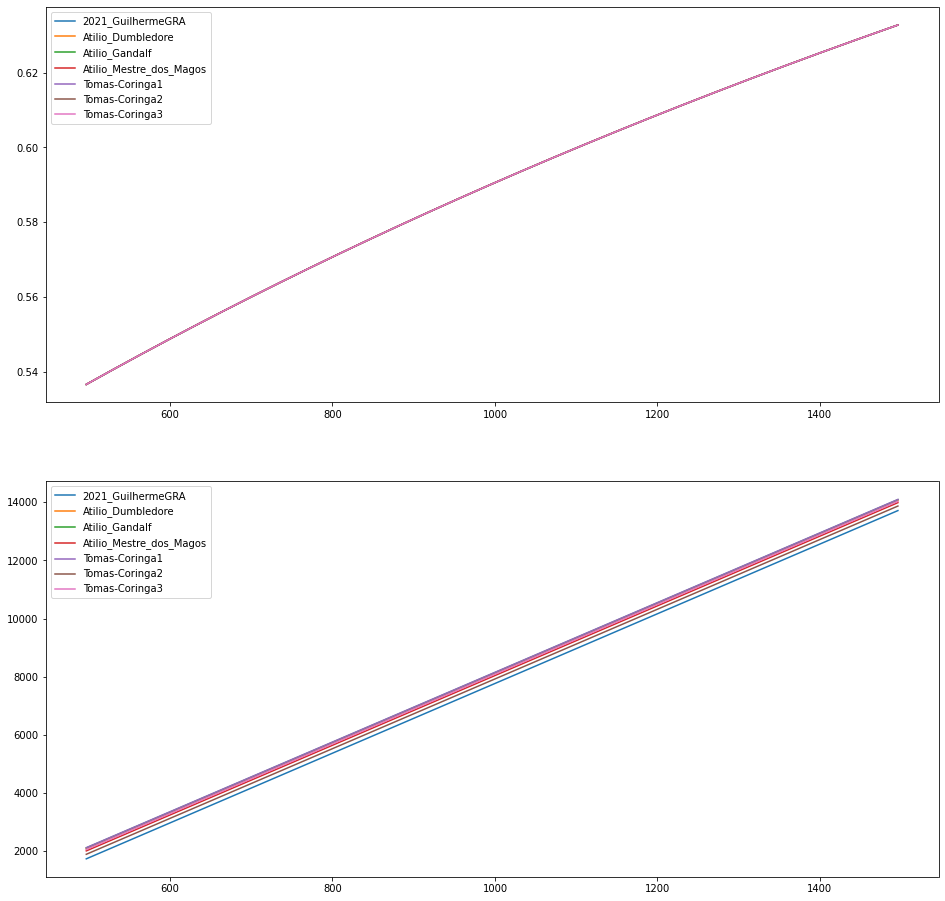

In [107]:
f, ax = plt.subplots(2,1, figsize=(16,16))
reputacao.plot(ax=ax[0])
comida.plot(ax=ax[1])